## 3. Sketching task – 1/2 A4 (Sharwin Bobde)
In a bloom filter we can have false positives because of collisions. The filter needs to be large and complex enough to approximate the frequency of a complex signal. An alternative is ***count-min sketching*** where we have multiple bloom filters with different hashing functions to reduce the chances of collisions.

In [1]:
import pandas as pd
from nltk import ngrams
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
# import discretised features
df = pd.read_csv("data/utils/discretized_scenario_10.csv")

Lets select only the `TotBytes_Dur` column to prove that count-min sketching is working.

In [3]:
items = df['TotBytes_Dur']
df["TotBytes_Dur"].value_counts()

0.0     111267
4.0       7223
1.0       2144
3.0       1242
2.0        130
19.0        50
15.0        41
18.0        40
16.0        26
13.0        25
9.0         10
17.0         1
Name: TotBytes_Dur, dtype: int64

### 3a. COUNT-MIN sketch
Please see the major implimentation in `count_min.py`

In [4]:
from count_min import count_min

items_3grams = list(ngrams(items, 3))

def get_cm(w, d):
    cm = count_min(width=w, d=d) # a new matrix
    for i in tqdm(range(len(items_3grams))):
        cm.add(items_3grams[i], 1) # add 1 count for this tuple (3gram)
    return cm


In [5]:
# get estimated counts... make a function :)
unique_items = np.unique(np.array(items_3grams), axis=0)

def get_estimates(cm):
    estimates = []
    for item in unique_items:
        estimates.append(cm.estimate(item))
    return np.array(estimates)

# get true counts for comparison
true_counts_dict = defaultdict(int)
for item in items_3grams:
    key = str(item)
    true_counts_dict[key] += 1

true_counts = []
for item in unique_items:
    key = str(tuple(item))
    true_counts.append(true_counts_dict[key])
true_counts= np.array(true_counts)

# sort in decreasing order
indices = np.argsort(true_counts)[::-1]
true_counts = true_counts[indices]
unique_items = unique_items[indices]

def error(estimated, true):
    ''' return sum of absolute difference '''
    return np.sum(np.abs(estimated - true))

### Experiment with changing width W
keeping sufficiently large $d = 10$

In [6]:
errors_w = []
W = [10, 20, 40, 80, 160, 320, 640]
for w in W:
    cm = get_cm(w, 16) 
    errors_w.append(error(get_estimates(cm), true_counts))
print(errors_w)

100%|██████████| 122197/122197 [00:07<00:00, 15522.97it/s][13151, 2245, 166, 6, 0, 0, 0]



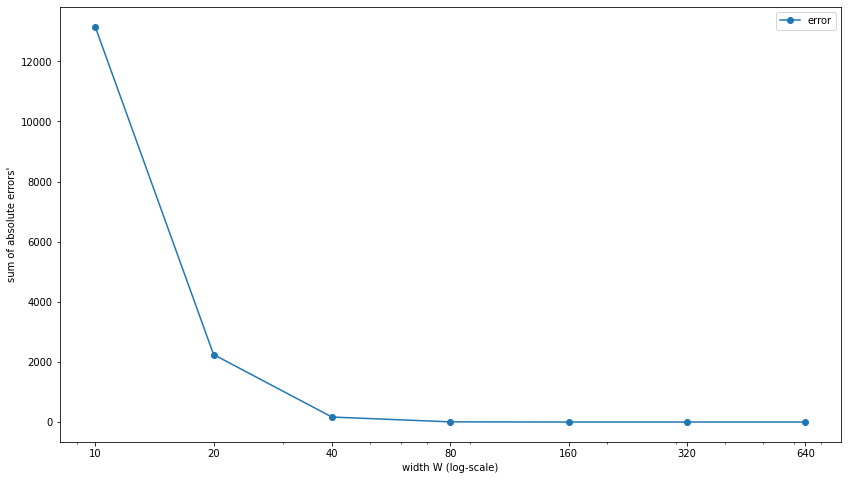

In [7]:
fig = plt.figure(figsize=(14,8))
plt.plot(W, errors_w, 'o-',label='error')
plt.xlabel("width W (log-scale)")
plt.ylabel("sum of absolute errors'")
plt.legend()
plt.xscale('log')
plt.xticks(W, labels=W)
plt.show()

### Experiment with changing no. of hashing functions d
keeping sufficiently large $W = 640$

In [8]:
errors_d = []
D = [2, 4, 8, 16, 20]
for d in D:
    cm = get_cm(45, d) 
    errors_d.append(error(get_estimates(cm), true_counts))
print(errors_d)

100%|██████████| 122197/122197 [00:09<00:00, 12896.76it/s][10839, 1400, 389, 137, 105]



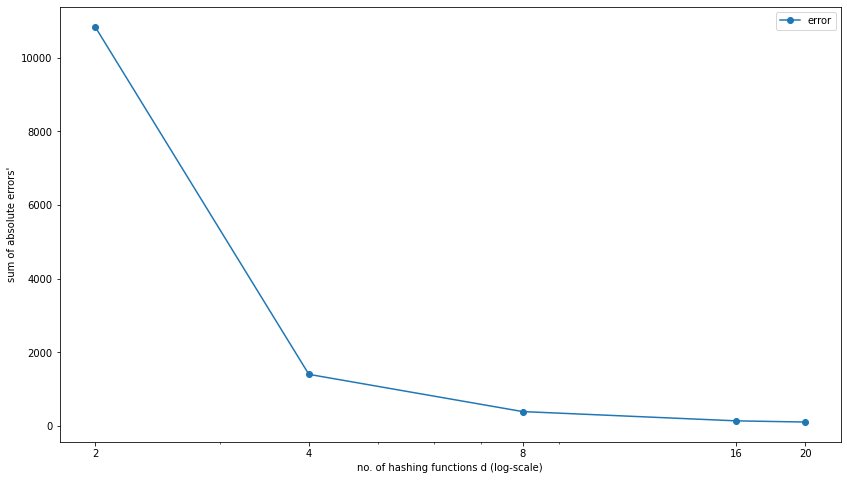

In [9]:
fig = plt.figure(figsize=(14,8))
plt.plot(D, errors_d, 'o-',label='error')
plt.xlabel("no. of hashing functions d (log-scale)")
plt.ylabel("sum of absolute errors'")
plt.legend()
plt.xscale('log')
plt.xticks(D, labels=D)
plt.show()

From the `tqdm()` output (time) we can see that increase in d, results in more computational overhead. This is because any W only require 1 modulo operation, whereas an increase in d requires more iterations.

### Example
lets fix d=10 and W=160

In [10]:
cm = get_cm(600, 20)
estimates = get_estimates(cm)
print('\n')
print(cm.array_)
print(np.shape(cm.array_))

100%|██████████| 122197/122197 [00:09<00:00, 12361.50it/s]

[[ 0  0  0 ...  1  0  0]
 [ 0  0 97 ...  0  0 11]
 [ 0  0  1 ...  0  0  0]
 ...
 [39  0  0 ...  0  3  0]
 [ 0  8  0 ...  0  0  0]
 [ 0 46  1 ...  0  0  0]]
(20, 600)



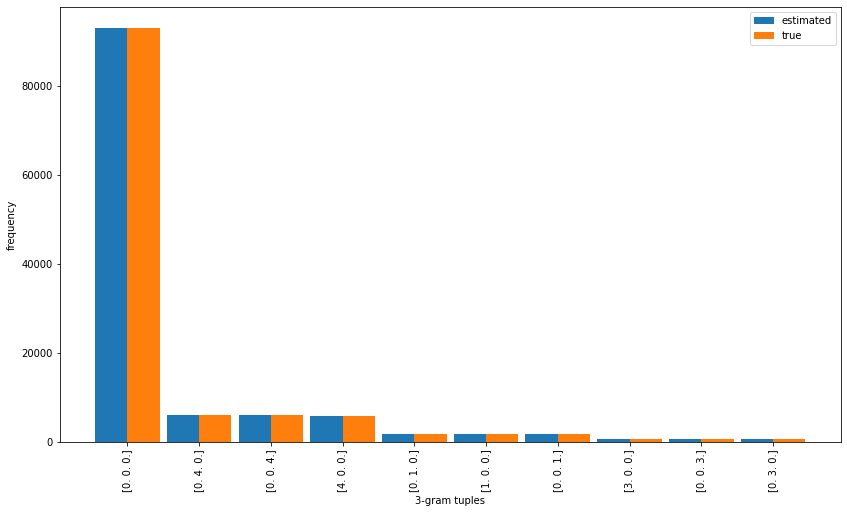

In [11]:
labels = [str(i) for i in unique_items]
barWidth = 0.45
r1 = np.arange(len(labels[0:10]))
r2 = [x + barWidth for x in r1]

fig = plt.figure(figsize=(14,8))
plt.bar(r1, estimates[0:10], width=barWidth, label='estimated')
plt.bar(r2, true_counts[0:10], width=barWidth, label='true')

plt.xlabel("3-gram tuples")
plt.ylabel("frequency")
plt.xticks([r + barWidth/2 for r in range(10)], rotation=90,labels=labels[0:10])
plt.legend()
plt.show()

### 3b. Analysis and answers to the questions

Thus, we can also see the **10 most common** 3-gram tuples in the above graph.
We don't see any errors because I have set W and d sufficiently large to 'sketch' this feature well.